## Install necessary packages

In [2]:
import os
from datetime import datetime

import openai
from IPython.display import HTML, display
from ipywidgets import widgets
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import DirectoryLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

## OpenAI API Key
Create a free account at https://beta.openai.com/ and copy your API key from the dashboard.
Then, create a text file by the name `api_key.txt` and paste your API key in it.

In [1]:
# read API key from text file
def read_api_key(file):
    with open(file, "r") as f:
        return f.read().strip()

In [3]:
os.environ["OPENAI_API_KEY"] = read_api_key("api_key.txt")

## HTML Chat App
The following codes will create a chat app using HTML withing the notebook. This is not necessary for the model to work, but it is a nice way to interact with the model. You can also use the model as a simple function output thing.

In [5]:
%%html
<link rel="stylesheet" 
      href="https://cdn.jsdelivr.net/npm/bootstrap@4.5.3/dist/css/bootstrap.min.css" 
      integrity="sha384-TX8t27EcRE3e/ihU7zmQxVncDAy5uIKz4rEkgIXeMed4M0jlfIDPvg6uqKI2xXr2" 
      crossorigin="anonymous">
<style>
    body{margin-top:20px;}

    .chat-message-left,
    .chat-message-right {
        display: flex;
        flex-shrink: 0
    }

    .chat-message-left {
        margin-right: auto
    }

    .chat-message-right {
        flex-direction: row-reverse;
        margin-left: auto
    }
</style>

## Data preparation
Initially, I had the data downloaded from R for Data Science's github repository. The files came in QMD format which can also be used to create embeddings but I converted them to text files.

In [6]:
import os
import subprocess

def convert_qmd_to_txt(source, destination):
  # get the list of qmd files in the source directory
  qmd_files = [f for f in os.listdir(source) if f.endswith(".qmd")]
  # loop through the qmd files and convert them to txt using pandoc
  for qmd_file in qmd_files:
    # get the input and output file paths
    input_file = os.path.join(source, qmd_file)
    output_file = os.path.join(destination, qmd_file.replace(".qmd", ".txt"))
    # run pandoc as a subprocess with the input and output file paths
    subprocess.run(["pandoc", "-o", output_file, input_file])

In [8]:
convert_qmd_to_txt("r4ds_book",
                   "documents")

[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to markdown
[WARNING] Could not deduce format from file extension .qmd
  Defaulting to m

## Generating the embeddings
The first step to create embeddings is to get the data loaded in using Langchain's DirectoryLoader. Then, use OpenAI's API to generate the embeddings. The embeddings are saved in a pickle file.

In [9]:
loader = DirectoryLoader("documents/", glob="*.*")
txt_docs = loader.load_and_split()

embeddings = OpenAIEmbeddings()

In [13]:
txt_docsearch = Chroma.from_documents(txt_docs, embeddings, persist_directory="txt_docsearch")

Using embedded DuckDB with persistence: data will be stored in: txt_docsearch


In [14]:
# I am using GPT-3.5-turbo model for this example. If you want more powerful model, use GPT-4
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.2)

### Conversation creator

In [15]:
qa = ConversationalRetrievalChain.from_llm(llm, retriever=txt_docsearch.as_retriever())
chat_history = []


def text_eventhandler(*args):
    # Needed bc when we "reset" the text input
    # it fires instantly another event since
    # we "changed" it's value to ""
    if args[0]["new"] == "":
        return

    # Show loading animation
    loading_bar.layout.display = "block"

    # Get question
    question = args[0]["new"]

    # Reset text field
    args[0]["owner"].value = ""

    # Formatting question for output
    q = (
        f'<div class="chat-message-right pb-4"><div>'
        + f'<img src="images/kitten.png" class="rounded-circle mr-1" width="40" height="40">'
        + f'<div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>'
        + '<div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">You</div>{question}</div>'
    )

    # Display formatted question
    output.append_display_data(HTML(q))

    try:
        response = qa({"question": f"{question}", "chat_history": chat_history})
        answer = response["answer"]
        chat_history.append((question, answer))
    except Exception as e:
        answer = "<b>Error:</b> " + str(e)

    # Formatting answer for output
    # Replacing all $ otherwise matjax would format them in a strange way
    answer_formatted = answer.replace("$", r"\$")
    a = (
        f'<div class="chat-message-left pb-4"><div>'
        + f'<img src="images/smokey.png" class="rounded-circle mr-1" width="40" height="40">'
        + f'<div class="text-muted small text-nowrap mt-2">{datetime.now().strftime("%H:%M:%S")}</div></div>'
        + '<div class="flex-shrink-1 bg-light rounded py-2 px-3 ml-3">'
        + f'<div class="font-weight-bold mb-1">LLM</div>{answer_formatted}</div>'
    )

    # Turn off loading animation
    loading_bar.layout.display = "none"

    output.append_display_data(HTML(a))

In [16]:
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()

file = open("images/loading.gif", "rb")
image = file.read()
loading_bar = widgets.Image(
    value=image, format="gif", width="20", height="20", layout={"display": "None"}
)

In [17]:
display(
    widgets.HBox(
        [output],
        layout=widgets.Layout(
            width="100%",
            max_height="500px",
            display="inline-flex",
            flex_flow="column-reverse",
        ),
    )
)


display(
    widgets.Box(
        children=[loading_bar, in_text],
        layout=widgets.Layout(display="flex", flex_flow="row"),
    )
)

Box(children=(Image(value=b'GIF89a\xc8\x00\xc8\x00\xf7\x00\x00;Ch\x83\x90\xb7\xcf\xdc\xe8\xda\xec\xf1\xf1\xf2\…

## Example Chats

![Screenshot 2023-08-28 at 11.05.30 PM.png](<attachment:Screenshot 2023-08-28 at 11.05.30 PM.png>)
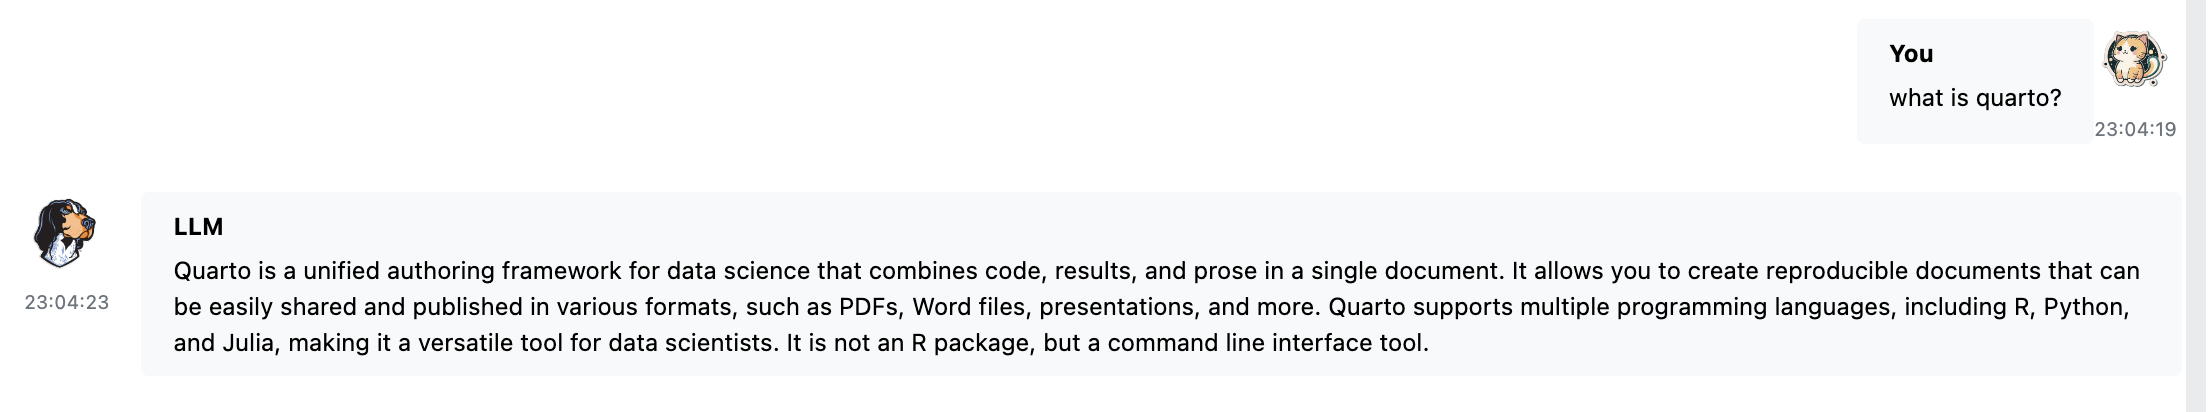

![Screenshot 2023-08-28 at 11.02.27 PM.png](<attachment:Screenshot 2023-08-28 at 11.02.27 PM.png>)
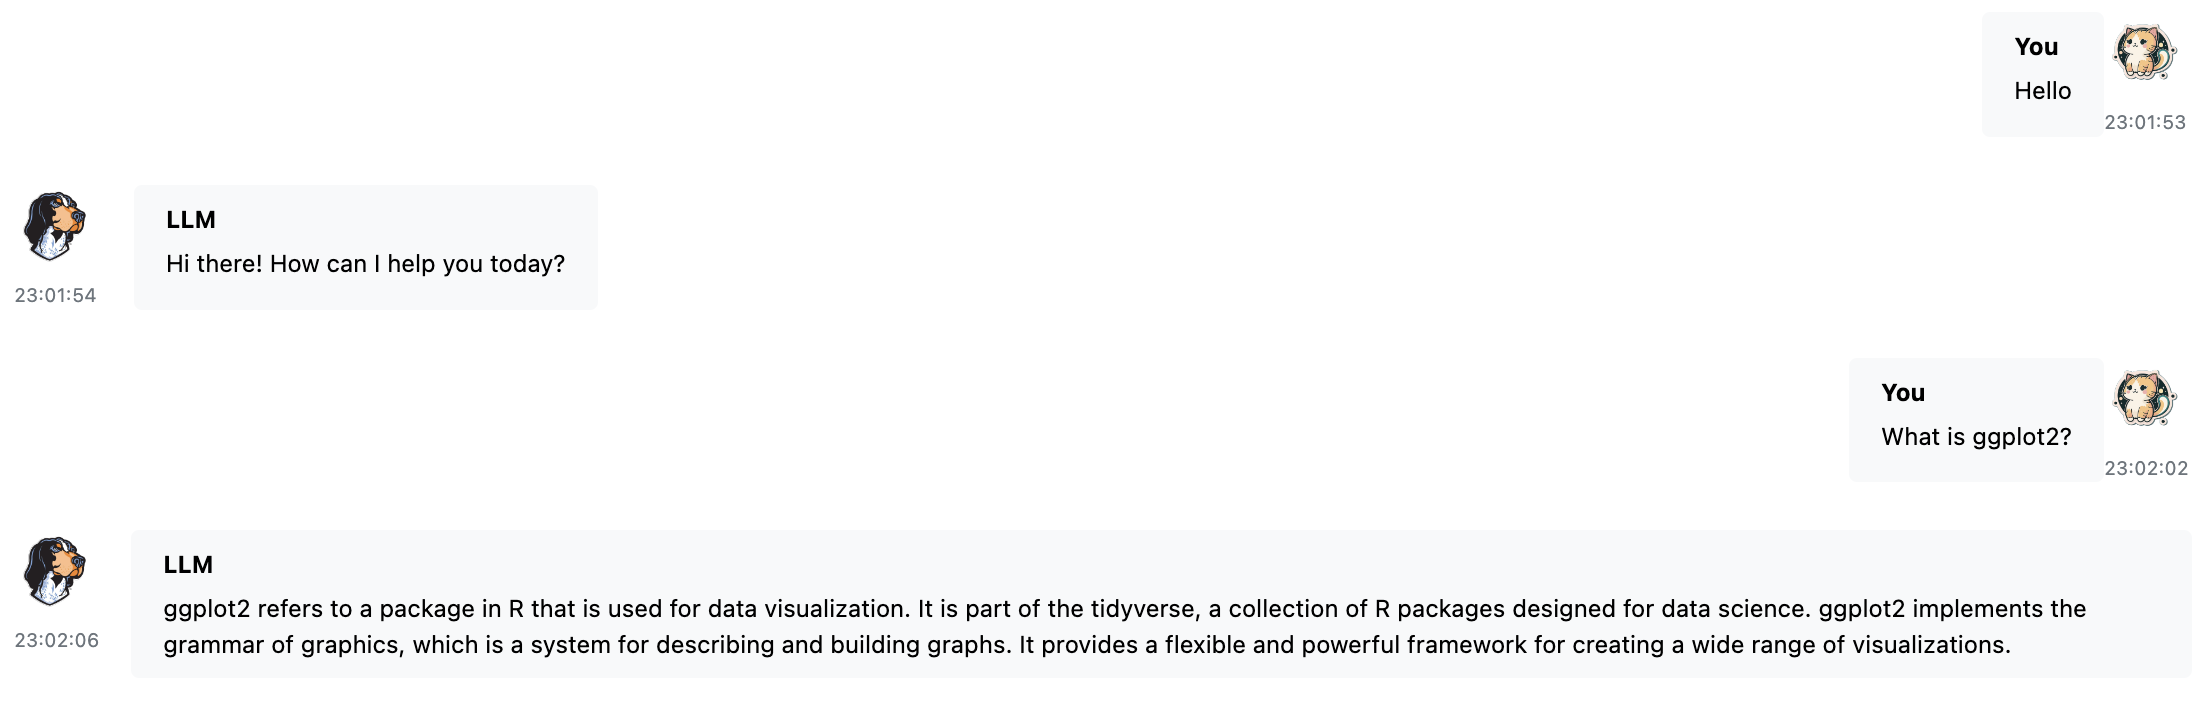

![Screenshot 2023-08-28 at 11.03.28 PM.png](<attachment:Screenshot 2023-08-28 at 11.03.28 PM.png>)
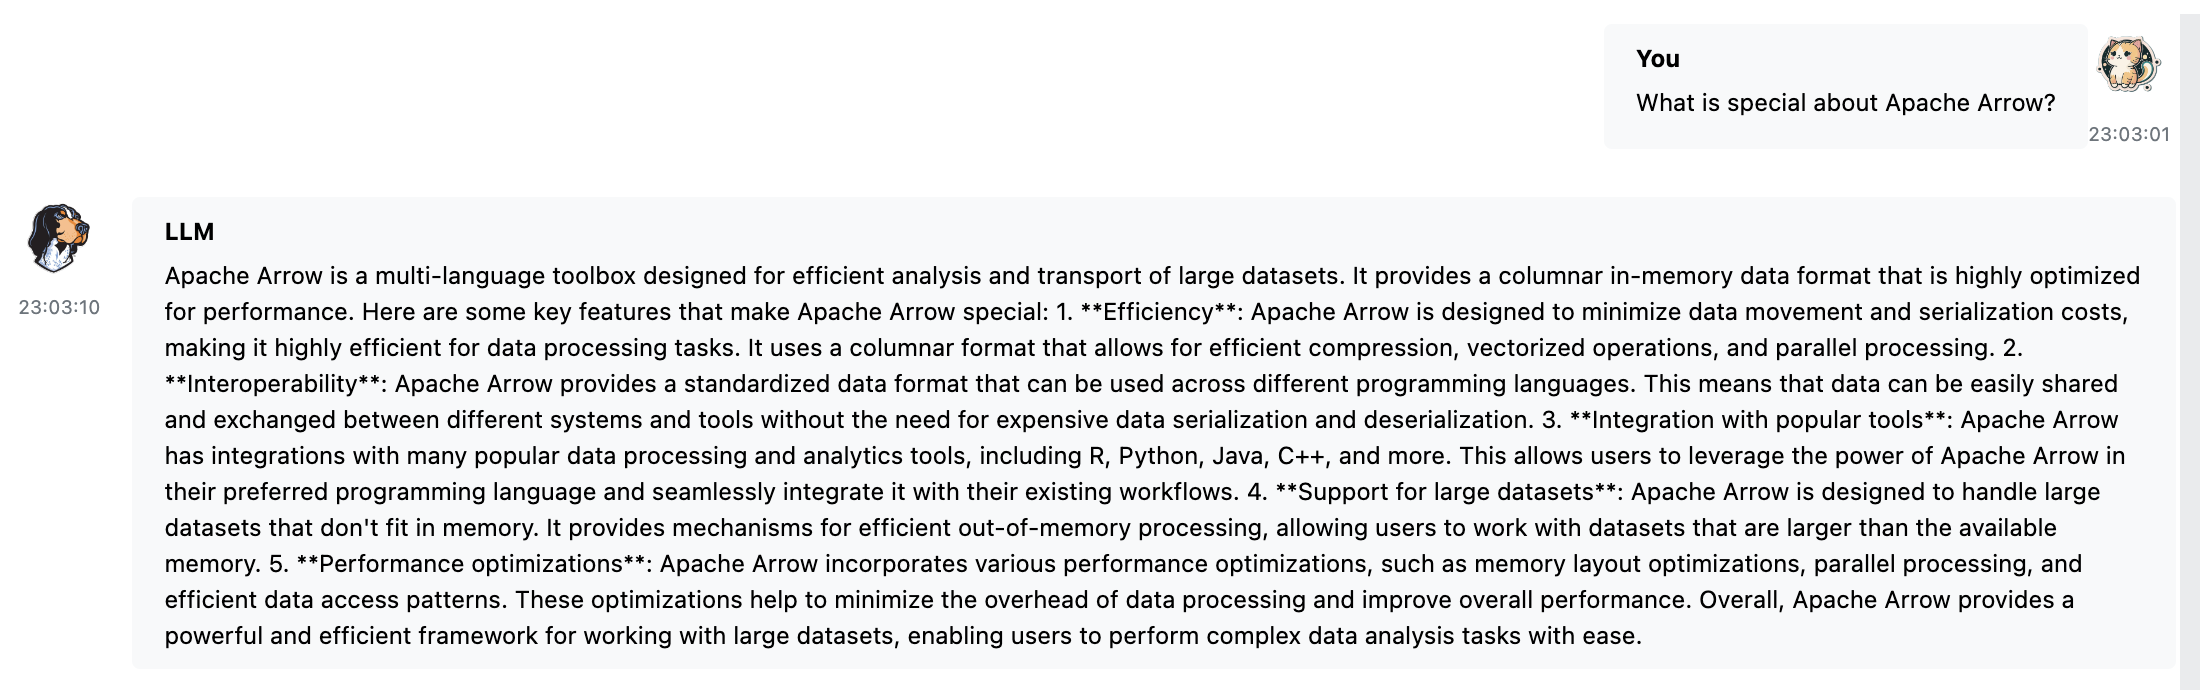